In [1]:
import time
# science
import numpy as np
import torch
from einops import repeat, rearrange

In [2]:
import joblib
import sidechainnet

In [3]:
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [4]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [5]:
min_len = 100
for batch in dataloaders['train']:
    real_seqs = [''.join([VOCAB.int2char(aa) for aa in seq]) for seq in batch.int_seqs.numpy()]
    print("seq len", len(real_seqs[0]))
    try:
        for i in range(len(batch.int_seqs.numpy())):
            # get variables
            seq     = real_seqs[i]
            int_seq = batch.int_seqs[i]
            angles  = batch.angs[i]
            # get padding
            padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
            padding_seq    = (np.array([x for x in seq]) == "_").sum()
            # only accept sequences with right dimensions and no missing coords
            # if padding_seq == padding_angles:
            # print("paddings_match")
            # print("len coords", list(batch.crds[i].shape)[0]//3, "vs int_seq", len(int_seq))
            if list(batch.crds[i].shape)[0]//14 == len(int_seq):
                if len(seq) > min_len and padding_seq == padding_angles:
                    print("stopping at sequence of length", len(seq))
                    print(len(seq), angles.shape, padding_seq == padding_angles == list(batch.crds[i].shape)[0]//3)
                    print("paddings: ", padding_seq, padding_angles)
                    raise StopIteration
                else:
                    print("found a seq of length:", len(seq), "but below the threshold:", min_len)
    except StopIteration:
        break

seq len 128
found a seq of length: 128 but below the threshold: 100
found a seq of length: 128 but below the threshold: 100
stopping at sequence of length 128
128 torch.Size([128, 12]) tensor(False)
paddings:  8 tensor(8)


### Load joblib file

In [6]:
# joblib.dump({"seq": seq, "int_seq": int_seq, "angles": angles,
#              "id": batch.pids[i], "true_coords": batch.crds[i]}, "experiments/112_aas_seq_and_angles.joblib")
info = joblib.load("experiments/344_aas_seq_and_angles.joblib")
seq, int_seq, angles, id_, true_coords = info["seq"], info["int_seq"], info["angles"], info["id"], info["true_coords"]

padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
padding_seq    = (np.array([x for x in seq]) == "_").sum()

### Load algo

In [7]:
from massive_pnerf import *

In [8]:
# measure time to featurize
# %timeit build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [9]:
true_coords.shape

torch.Size([4816, 3])

In [10]:
# featurize
scaffolds = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq])
# modify scaffolds with true data
scaffolds_ = modify_scaffolds_with_coords(scaffolds, 
                                          rearrange(true_coords, '(l c) d -> l c d', c=14)[:-padding_seq])

In [11]:
scaffolds["bond_mask"].shape, scaffolds_["bond_mask"].shape

(torch.Size([331, 14]), torch.Size([331, 14]))

In [12]:
# %%timeit
n_iters = 1000
errors, errors_3d  = [], []
coords_wrapper = true_coords[:]
# do n times and check error
for i in range(n_iters):
    # modify scaffolds with true data
    scaffolds_ = modify_scaffolds_with_coords(scaffolds, 
                                              rearrange(coords_wrapper, '(l c) d -> l c d', c=14)[:-padding_seq])
    # scaffolds_ = scaffolds
    # convert coords - fold
    coords, mask = proto_fold(seq[:-padding_seq], **scaffolds_)
    coords_flat  = rearrange(coords, 'l c d -> (l c) d') 
    
    # align
    flat_mask = rearrange(scaffolds_["cloud_mask"], 'l d -> (l d)')
    coords_aligned, labels_aligned = kabsch_torch(coords_flat[flat_mask].t(),
                                                  true_coords[:-14*padding_angles][flat_mask].t())
    # create coord scaffolds
    scaff_coords_aligned = torch.zeros(coords_flat.shape).float()
    scaff_labels_aligned = torch.zeros(coords_flat.shape).float()
    # fill
    scaff_coords_aligned[flat_mask] = coords_aligned.t()
    scaff_labels_aligned[flat_mask] = labels_aligned.t()
    # replace vars
    coords_aligned, labels_aligned = scaff_coords_aligned, scaff_labels_aligned
        
    # record evolution
    errors.append(rmsd_torch(coords_aligned, labels_aligned).item())
    errors_3d.append( (coords_aligned - labels_aligned).abs().mean(dim=-2) )
    if i % 50 == 0:
        print(i, "RMSD is:", errors[-1], "|| abs_error in 3 axis:", errors_3d[-1])
    
    # update coords
    coords_wrapper = torch.zeros_like( rearrange(true_coords, '(l c) d -> l c d', c=14) )
    coords_wrapper[:-padding_angles][scaffolds_["cloud_mask"]] = rearrange(coords_aligned, '(l c) d -> l c d', c=14)[scaffolds_["cloud_mask"]]
    coords_wrapper = rearrange(coords_wrapper, 'l c d -> (l c) d')
    

0 RMSD is: 0.15416982769966125 || abs_error in 3 axis: tensor([0.0560, 0.0504, 0.0509])
50 RMSD is: 0.3965531289577484 || abs_error in 3 axis: tensor([0.0890, 0.0645, 0.0853])
100 RMSD is: 0.42116546630859375 || abs_error in 3 axis: tensor([0.0730, 0.1114, 0.0786])
150 RMSD is: 0.40663039684295654 || abs_error in 3 axis: tensor([0.0733, 0.0894, 0.0770])
200 RMSD is: 0.40892958641052246 || abs_error in 3 axis: tensor([0.1160, 0.0950, 0.0606])
250 RMSD is: 0.4405646026134491 || abs_error in 3 axis: tensor([0.0941, 0.0970, 0.0758])
300 RMSD is: 0.4526323676109314 || abs_error in 3 axis: tensor([0.0918, 0.0839, 0.0805])
350 RMSD is: 0.42178452014923096 || abs_error in 3 axis: tensor([0.0865, 0.0863, 0.0781])
400 RMSD is: 0.4470149874687195 || abs_error in 3 axis: tensor([0.0834, 0.0920, 0.0868])
450 RMSD is: 0.3547334372997284 || abs_error in 3 axis: tensor([0.0682, 0.0841, 0.0711])
500 RMSD is: 0.3762093782424927 || abs_error in 3 axis: tensor([0.0690, 0.0730, 0.0910])
550 RMSD is: 0.3497

#### Display

In [ ]:
# print info
id_, true_coords.shape, len(int_seq[:-padding_angles-1]), seq

In [54]:
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
# sb = sidechainnet.StructureBuilder(int_seq[:-padding_angles], crd=true_coords[:-14*padding_angles]) # coords_flat
# sb.to_3Dmol()

### Diagnose rotation matrix

In [40]:
flat_mask = rearrange(scaffolds["cloud_mask"], 'l d -> (l d)')
coords_aligned, labels_aligned = kabsch_torch(coords_flat[flat_mask].t(),
                                              true_coords[:-14*padding_angles][flat_mask].t())
# create coord scaffolds
scaff_coords_aligned = torch.zeros(coords_flat.shape).float()
scaff_labels_aligned = torch.zeros(coords_flat.shape).float()
# fill
scaff_coords_aligned[flat_mask] = coords_aligned.t()
scaff_labels_aligned[flat_mask] = labels_aligned.t()
# replace vars
coords_aligned, labels_aligned = scaff_coords_aligned, scaff_labels_aligned

<IPython.core.display.Javascript object>


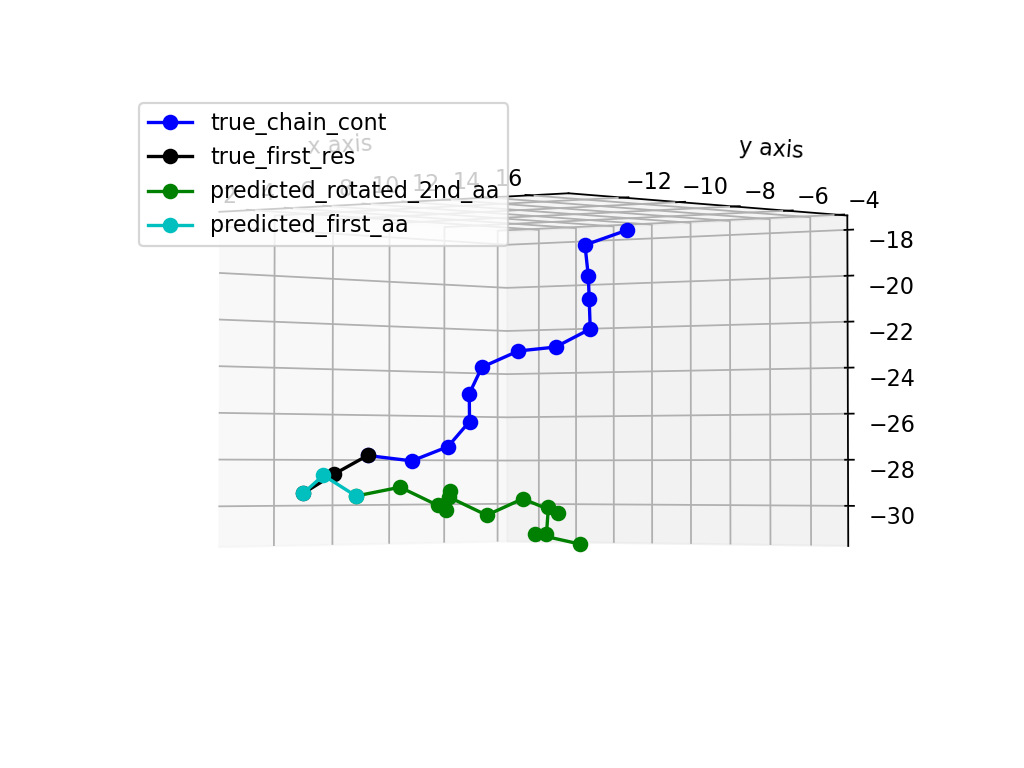

In [45]:
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot using Axes notation and standard function calls
start_res    = torch.cat([labels_aligned[:3, :],
                        labels_aligned[14:14+3],
                        labels_aligned[28:28+3],
                        labels_aligned[42:42+3],
                        labels_aligned[56:56+3]], dim=0).numpy()
destin_first = torch.cat([coords_aligned[:3, :],
                        coords_aligned[14:14+3],
                        coords_aligned[28:28+3],
                        coords_aligned[42:42+3],
                        coords_aligned[56:56+3]], dim=0).numpy()

destin_first -= (destin_first[:1] - start_res[:1])

ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "b-o", label="true_chain_cont")
ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "k-o", label="true_first_res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")

ax.plot(destin_first[2:, 0], destin_first[2:, 1], destin_first[2:, 2],  "g-o", label="predicted_rotated_2nd_aa")
ax.plot(destin_first[:3, 0], destin_first[:3, 1], destin_first[:3, 2],  "c-o", label="predicted_first_aa")

plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

In [42]:
boxel_pred_coords = rearrange(coords_aligned, '(l c) d -> l c d', c=14).numpy()
boxel_true_coords = rearrange(labels_aligned, '(l c) d -> l c d', c=14).numpy()

### Save oriented to manually diagnose

In [75]:
# save predicted
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_aligned) 
sb.to_pdb("preds/predicted_344.pdb")
sb = sidechainnet.StructureBuilder(int_seq, crd=labels_aligned) 
sb.to_pdb("preds/labels_344.pdb")
# go here: https://molstar.org/viewer/
# load chains and use superimposition tool

In [27]:
# sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
# sb.to_pdb("preds/predicted_112.pdb")